In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

In [3]:
def compute_hog(image, cell_size=(8, 8), block_size=(2, 2), n_bins=9):
    """
    Вычисляет HOG дескриптор для входного изображения.

    Аргументы:
    image -- 2D NumPy массив (grayscale изображение).
    cell_size -- (height, width) ячейки в пикселях.
    block_size -- (height, width) блока в ячейках.
    n_bins -- Количество бинов (корзин) в гистограмме ориентаций.

    Возвращает:
    (hog_descriptor, hog_image) -- 1D NumPy массив (HOG дескриптор) и
                                   3D NumPy массив (гистограммы ячеек для визуализации).
    """
    padded_image = np.pad(image, 1, mode='edge')
    
    gx = padded_image[1:-1, 2:] - padded_image[1:-1, :-2]
    gy = padded_image[2:, 1:-1] - padded_image[:-2, 1:-1]
    
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx)

    degrees = np.degrees(orientation) % 180
    
    img_h, img_w = image.shape
    cell_h, cell_w = cell_size
    block_h, block_w = block_size
    
    n_cells_y = img_h // cell_h
    n_cells_x = img_w // cell_w
    
    bin_size = 180. / n_bins
    
    cell_histograms = np.zeros((n_cells_y, n_cells_x, n_bins))

    for i in range(n_cells_y):
        for j in range(n_cells_x):
            
            y_start, y_end = i * cell_h, (i + 1) * cell_h
            x_start, x_end = j * cell_w, (j + 1) * cell_w
            
            cell_mag = magnitude[y_start:y_end, x_start:x_end]
            cell_ori = degrees[y_start:y_end, x_start:x_end]
            
            for y_pix in range(cell_h):
                for x_pix in range(cell_w):
                    
                    mag = cell_mag[y_pix, x_pix]
                    ori = cell_ori[y_pix, x_pix]
                    
                    bin_idx_float = ori / bin_size
                    bin_idx_1 = int(np.floor(bin_idx_float - 0.5))
                    bin_idx_2 = int(np.floor(bin_idx_float + 0.5))
                    
                    weight_2 = (bin_idx_float - 0.5) % 1.0
                    weight_1 = 1.0 - weight_2
                    
                    cell_histograms[i, j, bin_idx_1 % n_bins] += mag * weight_1
                    cell_histograms[i, j, bin_idx_2 % n_bins] += mag * weight_2

    n_blocks_y = n_cells_y - block_h + 1
    n_blocks_x = n_cells_x - block_w + 1
    
    hog_descriptor = []
    epsilon = 1e-5

    for i in range(n_blocks_y):
        for j in range(n_blocks_x):
            
            block_hist = cell_histograms[i : i + block_h, j : j + block_w, :]
            
            block_vector = block_hist.ravel()
            
            norm = np.sqrt(np.sum(block_vector**2) + epsilon**2)
            normalized_vector = block_vector / norm
            
            hog_descriptor.append(normalized_vector)
            
    return np.concatenate(hog_descriptor), cell_histograms

In [4]:
def visualize_hog_cells(image, cell_histograms, cell_size, n_bins):
    """
    Визуализирует HOG "глифы" (линии) поверх изображения.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image, cmap='gray')
    
    cell_h, cell_w = cell_size
    n_cells_y, n_cells_x, _ = cell_histograms.shape
    
    bin_centers = np.arange(0, 180, 180. / n_bins) + (180. / n_bins / 2.)
    
    for i in range(n_cells_y):
        for j in range(n_cells_x):
            
            center_y = i * cell_h + cell_h / 2
            center_x = j * cell_w + cell_w / 2
            
            hist = cell_histograms[i, j, :]
            
            hist = hist / (np.sum(hist**2)**0.5 + 1e-5)
            
            for k in range(n_bins):
                angle = np.deg2rad(bin_centers[k])
                magnitude = hist[k]
                
                dx = np.cos(angle) * magnitude * (cell_w / 2) * 0.8
                dy = -np.sin(angle) * magnitude * (cell_h / 2) * 0.8 
                
                x1, y1 = center_x - dx, center_y - dy
                x2, y2 = center_x + dx, center_y + dy
                
                ax.plot([x1, x2], [y1, y2], color='white', linewidth=2)

    ax.set_title("HOG Визуализация")
    ax.set_axis_off()
    plt.show()

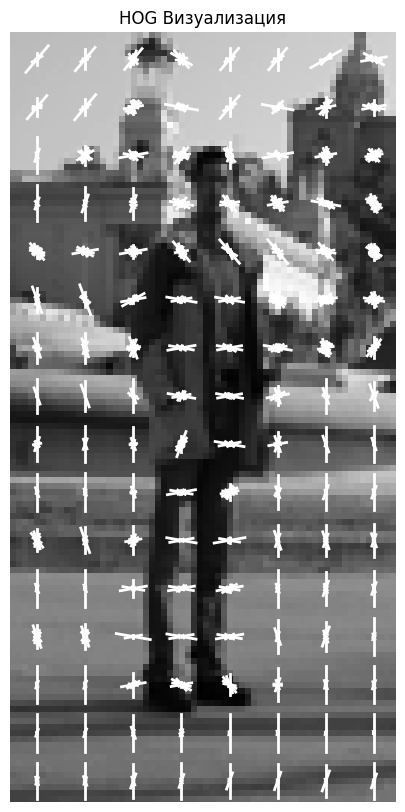

In [17]:
CELL_SIZE = (8, 8)
BLOCK_SIZE = (2, 2)
N_BINS = 9

image = Image.open('person_dataset/Pos/crop_000002.png')
image = image.convert('L').resize((64, 128))

image = np.array(image, dtype=float) / 255.0

hog_descriptor, hog_cells = compute_hog(
    image, 
    cell_size=CELL_SIZE, 
    block_size=BLOCK_SIZE, 
    n_bins=N_BINS
)

visualize_hog_cells(image, hog_cells, CELL_SIZE, N_BINS)

In [22]:
import os

pos_img_path = 'person_dataset/Pos/'
neg_img_path ='person_dataset/Neg/'

pos_images = os.listdir(pos_img_path)
neg_images = os.listdir(neg_img_path)

X = []
y = []

for pos_image in pos_images:

    image = Image.open(pos_img_path + pos_image)
    image = image.convert('L').resize((64, 128))
    image = np.array(image, dtype=float) / 255.0

    hog_vect, _ = compute_hog(image)

    X.append(hog_vect)
    y.append(1)

for neg_image in neg_images:

    image = Image.open(neg_img_path + neg_image)
    image = image.convert('L').resize((64, 128))
    image = np.array(image, dtype=float) / 255.0

    hog_vect, _ = compute_hog(image)

    X.append(hog_vect)
    y.append(0)

X = np.array(X)
y = np.array(y)

In [20]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

model = LinearSVC(C=1.0, max_iter=10000, dual=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

joblib.dump(model, 'pedestrian_detector_svm.pkl')

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       304
           1       0.81      0.79      0.80       184

    accuracy                           0.85       488
   macro avg       0.84      0.84      0.84       488
weighted avg       0.85      0.85      0.85       488



['pedestrian_detector_svm.pkl']

In [29]:
def non_maximum_suppression(boxes, overlap_thresh, win_w, win_h):
    """
    Выполняет подавление немаксимумов на списке рамок.
    
    Аргументы:
    boxes -- Список кортежей (x, y, w, h, confidence) или (x, y, confidence)
             для детекций, где (x, y) - верхний левый угол, w/h - ширина/высота.
             confidence - уверенность классификатора.
    overlap_thresh -- Порог перекрытия (IoU - Intersection over Union).
                      Если IoU > overlap_thresh, рамки считаются перекрывающимися.

    Возвращает:
    selected_boxes -- Список отобранных рамок.
    """
    if len(boxes[0]) == 3:
        temp_boxes = []
        for (x, y, conf) in boxes:
            temp_boxes.append([x, y, x + win_w, y + win_h, conf])
        boxes = np.array(temp_boxes)
    else: 
        boxes = np.array(boxes)

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] 
    y2 = boxes[:, 3] 
    scores = boxes[:, 4]

    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        area = (x2[order] - x1[order]) * (y2[order] - y1[order])

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)

        inter = w * h

        union = (area[0] + area[1:] - inter)
        iou = inter / (union + 1e-6) 

        inds = np.where(iou <= overlap_thresh)[0]
        order = order[inds + 1] 

    selected_boxes = []
    for idx in keep:
        x, y = int(boxes[idx, 0]), int(boxes[idx, 1])
        w = int(boxes[idx, 2] - boxes[idx, 0])
        h = int(boxes[idx, 3] - boxes[idx, 1])
        conf = boxes[idx, 4]
        selected_boxes.append((x, y, w, h, conf))
        
    return selected_boxes

In [27]:
import matplotlib.patches as patches

In [ ]:
CELL_SIZE = (8, 8)
BLOCK_SIZE = (2, 2)
N_BINS = 9

WIN_H, WIN_W = 128, 64 

STEP_SIZE = 8 
CONFIDENCE_THRESHOLD = 0.5 
NMS_OVERLAP_THRESHOLD = 0.3 

original_image = Image.open('src/12.jpg').convert('RGB')
gray_image_for_hog = original_image.convert('L') 

gray_image_for_hog_np = np.array(gray_image_for_hog, dtype=float) / 255.0

all_detections = [] 

img_h, img_w = gray_image_for_hog_np.shape

if img_h < WIN_H or img_w < WIN_W:
    scale_factor = max(WIN_H / img_h, WIN_W / img_w, 1.0) * 1.5
    new_h, new_w = int(img_h * scale_factor), int(img_w * scale_factor)
    
    original_image = original_image.resize((new_w, new_h), Image.Resampling.LANCZOS)
    gray_image_for_hog = gray_image_for_hog.resize((new_w, new_h), Image.Resampling.LANCZOS)
    gray_image_for_hog_np = np.array(gray_image_for_hog, dtype=float) / 255.0
    
    img_h, img_w = gray_image_for_hog_np.shape

for y in range(0, img_h - WIN_H + 1, STEP_SIZE):
    for x in range(0, img_w - WIN_W + 1, STEP_SIZE):
        
        patch = gray_image_for_hog_np[y : y + WIN_H, x : x + WIN_W]
        
        if patch.shape[0] != WIN_H or patch.shape[1] != WIN_W:
            continue 
        
        features, _ = compute_hog(patch, cell_size=CELL_SIZE, block_size=BLOCK_SIZE, n_bins=N_BINS)
        
        confidence = model.decision_function([features])[0] 

        if confidence > CONFIDENCE_THRESHOLD:
            all_detections.append((x, y, confidence))

print(f"Найдено {len(all_detections)} исходных детектирований.")

final_detections = non_maximum_suppression(all_detections, NMS_OVERLAP_THRESHOLD, WIN_W, WIN_H)
print(f"После NMS осталось {len(final_detections)} детектирований.")

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(original_image) 

for (x, y, w, h, conf) in final_detections:
    rect = patches.Rectangle(
        (x, y), w, h,
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(
        x, y - 5, f'{conf:.2f}', 
        bbox=dict(facecolor='red', alpha=0.5), 
        fontsize=8, color='white'
    )

ax.set_title(f"HOG + SVM Детекция ({len(final_detections)} объектов)")
ax.axis('off')
plt.show()